In [1]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def DxCD(N,M,bc="Dirichlet",matrix=False):
    d = ([-2]+[0]*(N-2)+[2])*M
    dp = (([2]+[1]*(N-2)+[0])*M)[:-1]
    dm = (([-1]*(N-2)+[-2]+[0])*M)[:-1]
    if matrix:
        return .5*(np.diag(d)+np.diag(dp,1)+np.diag(dm,-1))
    return .5*dm,.5*d,.5*dp

In [3]:

def DyCD(N,M,matrix=False):
    d = [2]*(N)+([0]*(M-2))*(N)+[2]*(N)
    dp = ([0]*N)+([1]*(M-2)*(N))
    dm = ([-1]*(M-2)*N+[-2]*N)
    if matrix:
        return .5*(np.diag(d)+np.diag(dp,N)+np.diag(dm,-M))
    return .5*dm,.5*d,.5*dp

In [4]:
DxCD(3,3,matrix=True)

array([[-1. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [-0.5,  0. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. , -1. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , -1. ,  1. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , -0.5,  0. ,  0.5,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. , -1. ,  1. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. , -1. ,  1. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. , -0.5,  0. ,  0.5],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -1. ,  1. ]])

In [5]:
DyCD(3,3,matrix=True)

array([[ 1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [-0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0.5,  0. ,  0. ],
       [ 0. , -0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0.5,  0. ],
       [ 0. ,  0. , -0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0.5],
       [ 0. ,  0. ,  0. , -1. ,  0. ,  0. ,  1. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. , -1. ,  0. ,  0. ,  1. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. , -1. ,  0. ,  0. ,  1. ]])

In [6]:
def genLam(theta,shape,alpha=1,beta=.5):
    n,m = shape
    lamMinus=np.power(theta/alpha+(np.ones(n*m)-theta)/beta,-1)
    lamPlus=alpha*theta+beta*(np.ones(n*m)-theta)
    return lamMinus,lamPlus

def lam_theta(theta,shape,alpha=1,beta=.5):
  n,m=shape
  lamPlus_theta=-np.power((1/alpha-1/beta)*(theta/alpha+(np.ones(n*m)-theta)/beta),-2)
  lamMinus_theta=alpha*theta+beta*(np.ones(n*m)-theta)

def genA(theta,phi,shape,alpha=1,beta=.1):
    n,m = shape
    size=len(theta)
    A = np.zeros((size,2,2))
    lamPlus,lamMinus=genLam(theta,shape,alpha,beta)

    for idx in range(n*m):
        A1=lamPlus[idx]*np.cos(phi[idx])**2+lamMinus[idx]*np.sin(phi[idx])**2
        A2=(lamPlus[idx]+lamMinus[idx])*np.sin(phi[idx])*np.cos(phi[idx])
        A3=lamPlus[idx]*np.sin(phi[idx])**2+lamMinus[idx]*np.cos(phi[idx])**2
        
        A[idx]=np.array([[A1,A2],[A2,A3]])

    return A

def A_theta(thetaK,phiK,alpha=1,beta=.1):
  lamPlus_theta=-(1/alpha-1/beta)*((thetaK/alpha+(1-thetaK)/beta)**(-2))
  lamMinus_theta=alpha-beta

  A1=lamPlus_theta*np.cos(phiK)**2+lamMinus_theta*np.sin(phiK)**2
  A2=(lamPlus_theta+lamMinus_theta)*np.sin(phiK)*np.cos(phiK)
  A3=lamPlus_theta*np.sin(phiK)**2+lamMinus_theta*np.cos(phiK)**2
  
  A_theta=np.array([[A1,A2],[A2,A3]])
  return A_theta

def A_phi(thetaK,phiK,alpha=1,beta=.1):
  lamPlus=np.power(thetaK/alpha+(1-thetaK)/beta,-1)
  lamMinus=alpha*thetaK-beta*(1-thetaK)

  A1=(-lamPlus+lamMinus)*2*np.sin(phiK)*np.cos(phiK)
  A2=(-lamPlus+lamMinus)*(np.cos(phiK)**2-np.sin(phiK)**2)
  A3=(lamPlus-lamMinus)*2*np.sin(phiK)*np.cos(phiK)
  
  A_phi=np.array([[A1,A2],[A2,A3]])
  return A_phi

In [7]:
class heatLens():
    def __init__(self,x,y,f,gamma0,options={}):
        self.options=options
        self.check_options()

        self.n=len(x)
        self.m=len(y)
        self.hx = 1/(n+1)
        self.hy = 1/(m+1)
        self.domain_len = self.n*self.m
        self.domain_shape = (self.n,self.m)
        self.xx,self.yy=np.meshgrid(x,y)
        self.f=f
        self.theta=np.zeros(self.domain_len)
        self.phi=np.zeros(self.domain_len)
        self.gamma0 = gamma0

        Dx=DxCD(self.n,self.m,matrix=True)
        Dy=DyCD(self.n,self.m,matrix=True)
        self.Grad_flat=np.vstack((Dx,Dy))
        self.Div_flat=np.hstack((Dx.T,Dy.T))


        Div=np.zeros((self.domain_len,self.domain_len,2))
        Div[:,:,0]=Dx.T
        Div[:,:,1]=Dy.T
        self.Div=Div

        Grad=np.zeros((self.domain_len,2,self.domain_len))
        Grad[:,0,:]=Dx
        Grad[:,1,:]=Dy
        self.Grad=Grad

        A=self.Div_flat@self.Grad_flat
        u0=cp.Variable(self.domain_len)
        prob=cp.Problem(cp.Minimize(cp.sum_squares(A@u0-f)))
        prob.solve()
        self.u0=u0.value

    def iterate(self,k):
        for _ in range(k):
            self._iter()

    def _iter(self):

        alpha=self.options['alpha']
        beta=self.options['beta']
        lv=self.options['lv']
        tk=self.options['tk']
        Div = self.Div
        Grad = self.Grad

        A=genA(self.theta,self.phi,[self.n,self.m],alpha=alpha,beta=beta)
        B=np.tensordot(Div,A@Grad)
          
        u=cp.Variable(self.domain_len)
        prob=cp.Problem(cp.Minimize(cp.sum_squares(B@u-self.f)))
        prob.solve()
        u=u.value

        Du=(self.Grad_flat@u).reshape(2,self.domain_len)
        sol=B@u

        p=cp.Variable(self.domain_len)
        prob=cp.Problem(cp.Minimize(cp.sum_squares(B@p-(self.hx+self.hy)*self.gamma0)))
        prob.solve()
        p=p.value
        Dp=(self.Grad_flat@p).reshape(2,self.domain_len)

        for idx in range(self.domain_len):
            A_t=A_theta(self.theta[idx],self.phi[idx],alpha=alpha,beta=beta)
            rhs=self.theta[idx]-tk*(lv*A_t@Du[:,idx]@Dp[:,idx])
            self.theta[idx]=max([0,min([1,rhs])])

        for idx in range(self.domain_len):
            A_p=A_phi(self.theta[idx],self.phi[idx],alpha=alpha,beta=beta)
            self.phi[idx]=self.phi[idx]*tk*(A_p@Du[:,idx]@Dp[:,idx])
        self.ADu=(A@Grad)@u

    def check_options(self):
        if not('alpha' in self.options):
            self.options['alpha']=.01
        if not('beta' in self.options):
            self.options['beta']=1
        if not('tk' in self.options):
            self.options['tk']=.001
        if not('lv' in self.options):
            self.options['lv']=1

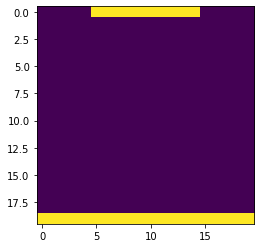

In [8]:
#GRID
n,m=20,20
y=np.linspace(0,1,n)
x=np.linspace(0,1,m)

# Initial Distribution
rho = np.zeros((n,m))
rho[-1,:] = np.ones(n)
f = rho.flatten()
gamma0 = np.zeros(n*m); gamma0[m//4:3*m//4]=np.ones(m//2)
plt.imshow(rho+gamma0.reshape(n,m))

In [9]:
options={'lv':100}
prob = heatLens(x,y,f,gamma0,options)
prob.iterate(50)

(2, 400) (2, 2) (2,) (2,) ()
(2, 400) (2, 2) (2,) (2,) ()
(2, 400) (2, 2) (2,) (2,) ()
(2, 400) (2, 2) (2,) (2,) ()
(2, 400) (2, 2) (2,) (2,) ()
(2, 400) (2, 2) (2,) (2,) ()
(2, 400) (2, 2) (2,) (2,) ()
(2, 400) (2, 2) (2,) (2,) ()
(2, 400) (2, 2) (2,) (2,) ()
(2, 400) (2, 2) (2,) (2,) ()
(2, 400) (2, 2) (2,) (2,) ()
(2, 400) (2, 2) (2,) (2,) ()
(2, 400) (2, 2) (2,) (2,) ()
(2, 400) (2, 2) (2,) (2,) ()
(2, 400) (2, 2) (2,) (2,) ()
(2, 400) (2, 2) (2,) (2,) ()
(2, 400) (2, 2) (2,) (2,) ()
(2, 400) (2, 2) (2,) (2,) ()
(2, 400) (2, 2) (2,) (2,) ()
(2, 400) (2, 2) (2,) (2,) ()
(2, 400) (2, 2) (2,) (2,) ()
(2, 400) (2, 2) (2,) (2,) ()
(2, 400) (2, 2) (2,) (2,) ()
(2, 400) (2, 2) (2,) (2,) ()
(2, 400) (2, 2) (2,) (2,) ()
(2, 400) (2, 2) (2,) (2,) ()
(2, 400) (2, 2) (2,) (2,) ()
(2, 400) (2, 2) (2,) (2,) ()
(2, 400) (2, 2) (2,) (2,) ()
(2, 400) (2, 2) (2,) (2,) ()
(2, 400) (2, 2) (2,) (2,) ()
(2, 400) (2, 2) (2,) (2,) ()
(2, 400) (2, 2) (2,) (2,) ()
(2, 400) (2, 2) (2,) (2,) ()
(2, 400) (2, 2

(-0.5, 19.5, 19.5, -0.5)

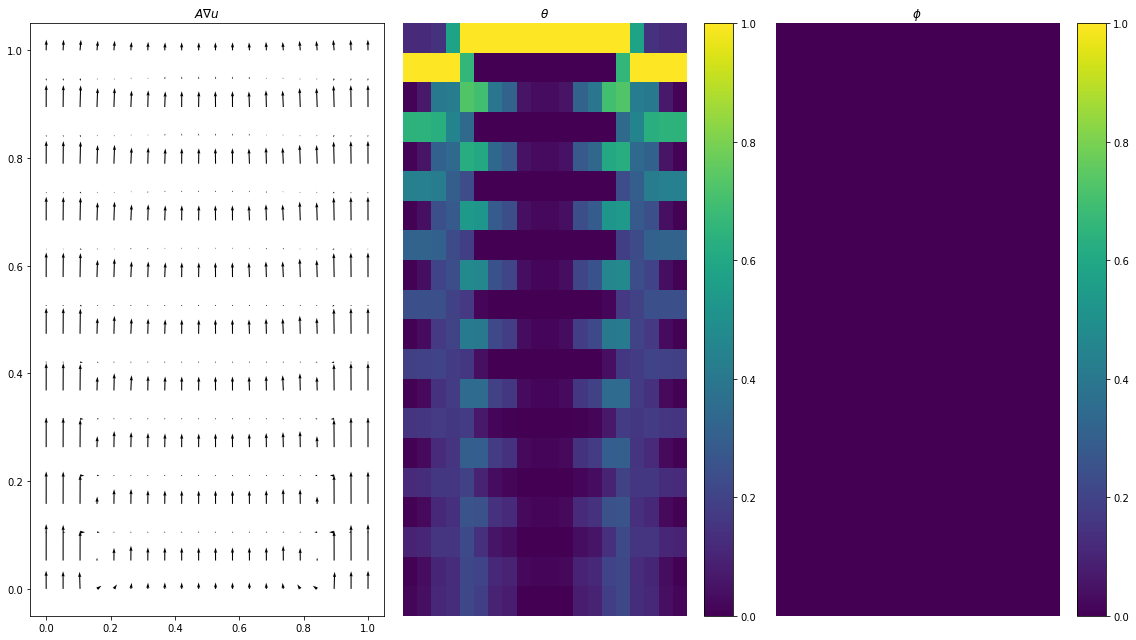

In [10]:


plt.figure(figsize=(16,9),tight_layout=True)
plt.subplot(131)
plt.quiver(prob.xx,prob.yy,prob.ADu.T[0],prob.ADu.T[1])
plt.title('$A\\nabla u$')
plt.subplot(132)
plt.imshow(prob.theta.reshape(prob.domain_shape),vmin=0,vmax=1,aspect='auto')
plt.colorbar()
plt.title('$\\theta$')
plt.axis('off')
plt.subplot(133)
plt.imshow(prob.phi.reshape(prob.domain_shape),vmin=0,vmax=1,aspect='auto')
plt.colorbar()
plt.title('$\\phi$')
plt.axis('off')

